To use, upload your data file (csv file output from survey) using the toolbar to the left, then click the run button. Enter the name of your data file and the minimum number of people in a group.

Run the script multiple times to generate different outputs. More-transparent nodes are not van-trained.

Outputs are saved as 'Groups.png' and 'Groups.txt'

Enter name of survey output file: Data_Raw.csv
Data successfully read
Minimum group size:4


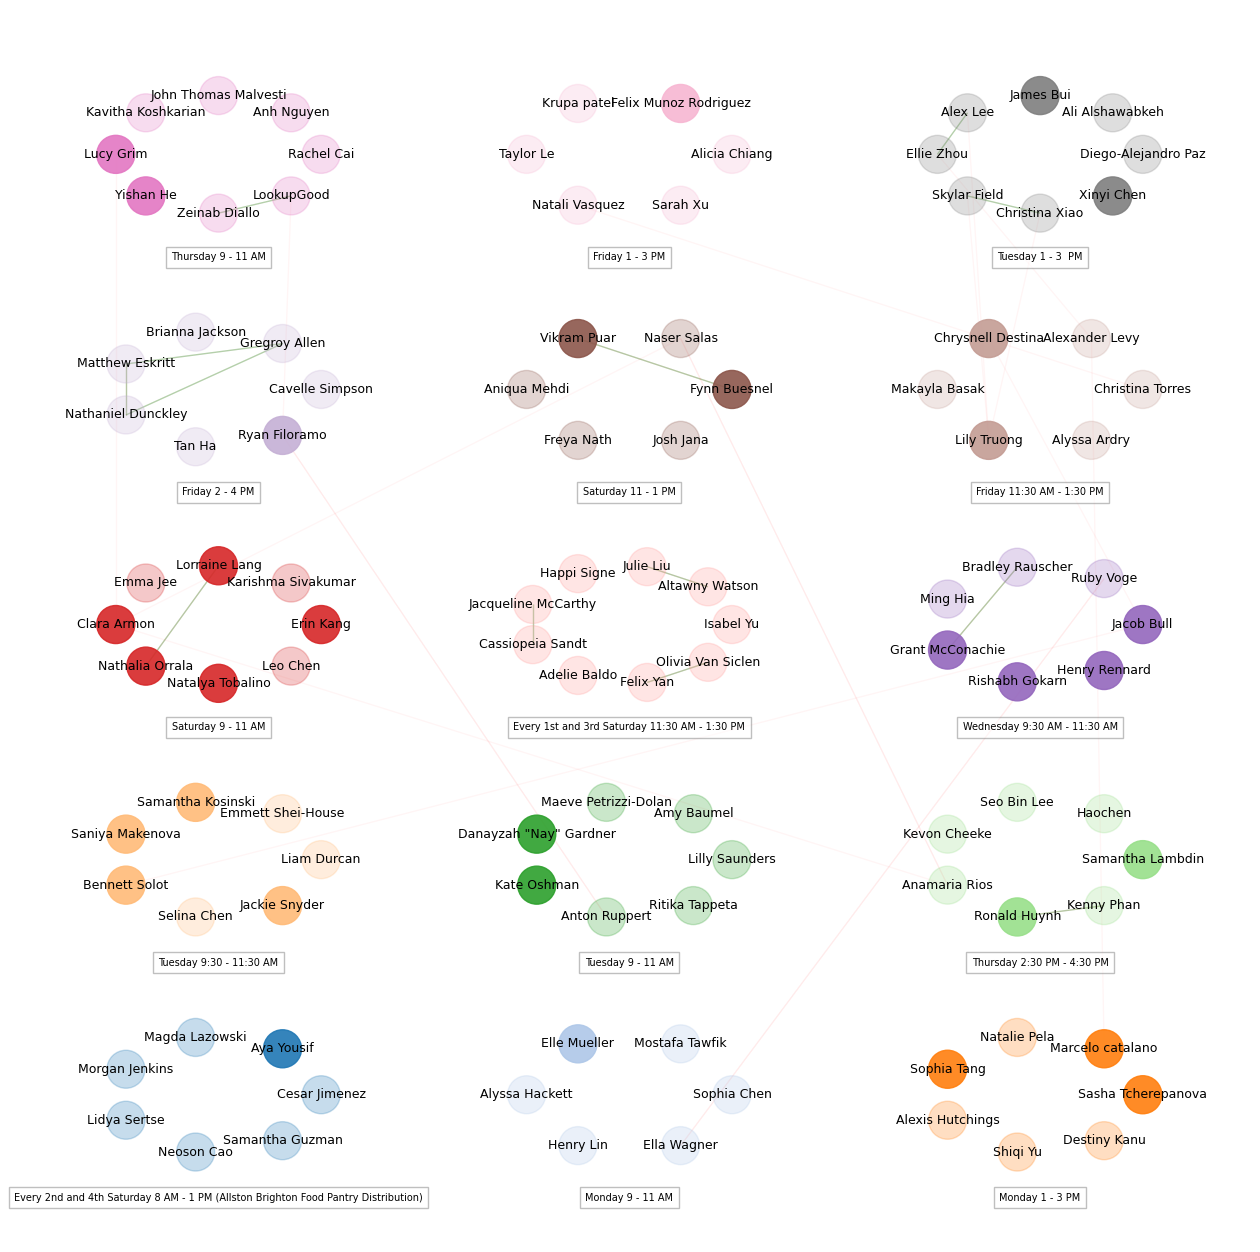

In [7]:
# @title Code
import numpy as np
import pandas as pd
from rapidfuzz import process, fuzz
import networkx as nx
import matplotlib.pyplot as plt
import random
from collections import defaultdict
import matplotlib.cm as cm

##################################
## Step 1: Read in, format data ##
##################################

# input name of file with data
file_path = input("Enter name of survey output file: ")

# read in data
try:
    data = pd.read_csv(file_path)
    print("Data successfully read")
except FileNotFoundError:
    print(f"File not found: {file_path}")
except pd.errors.EmptyDataError:
    print("No data found in file.")
except Exception as e:
    print(f"An error occurred: {e}")

# name of relevant columns to extract from file
names_col = "First and Last Name"
email_col = "BU email"
alreadyvantrained_col = "Have you been previously van trained by the Community Service Center?"
wanttovantrain_col = "Would you like to be van trained?"
option1_col = "Please check your FIRST CHOICE of run assignment."
option2_col = "Please check your SECOND CHOICE of run assignment."
option3_col = "Please check your THIRD CHOICE of run assignment."
requests_col = "Please list the names of fellow volunteers that you'd like to be placed on a run with. Please note that we cannot guarantee that you will receive the same run assignment, especially if you do not have overlapping availability. \nLeave blank if N/A.\nEnter just first and last names separated by commas: Eleanor Hoffpauir, Ocean Bruinius"

# extract relevant columns from file
columns_to_extract = [names_col,email_col,alreadyvantrained_col,wanttovantrain_col,option1_col,option2_col,option3_col,requests_col]
data = data[columns_to_extract]

pd.set_option('future.no_silent_downcasting', True)

data[alreadyvantrained_col] = data[alreadyvantrained_col].replace({'Yes': 1, 'No': 0})
data[wanttovantrain_col] = data[wanttovantrain_col].replace({'Yes': 1, 'No': 0})
data['vantrained'] = (data[alreadyvantrained_col] == 1) | (data[wanttovantrain_col] == 1)
data['vantrained'] = data['vantrained'].astype(int)

data[names_col] = data[names_col].str.rstrip()

# gather timeslots
option_cols = [option1_col,option2_col,option3_col]
unique_values = set()
for column in option_cols:
    unique_values.update(data[column].unique())

num_timeslots = len(unique_values)

# add encodings to dataframe
for value in unique_values:
    data[value]=0

# transform to many-hot encodings
for col in option_cols:
    for index, row in data.iterrows():
        value = row[col]
        # Set the corresponding column that matches 'value' to 1
        data.at[index, value] = 1

# drop original columns
data = data.drop(option_cols,axis=1)

data = data.drop_duplicates(subset=email_col,keep='last')
data = data.drop_duplicates(subset=names_col,keep='last')

data = pd.concat([data, data[requests_col].str.split(', ', expand=True)], axis=1)
data = data.drop(columns=[requests_col])

###############################
## Step 2: Fuzzy match names ##
###############################

ground_truth = data[names_col]
fuzzy =  set()

for column_name in data.columns:
    # Check if the column name is an integer
    if isinstance(column_name, int):
        # Update the unique values set with the unique values from this column
        fuzzy.update(data[column_name].unique())

ground_truth = ground_truth.apply(str.strip)
fuzzy = {str(name).strip() for name in fuzzy}

# Initialize an empty dictionary to store matches
matches = {}

# Iterate over each name in the fuzzy set
for name in fuzzy:
    # Use process.extractOne to find the best match with the ratio scorer
    best_match = process.extractOne(name, ground_truth, scorer=fuzz.ratio)

    # Check if a match was found
    if best_match:
        # Calculate likelihood (as a probability)
        likelihood = best_match[1] / 100.0
        # cull matches under threshold .75
        if likelihood >= .75:
            # Store the result in the matches dictionary
            matches[name] = (best_match[0])
    else:
        # Optionally handle cases where no match is found
        matches[name] = (None)

# Convert the result to a DataFrame for easier viewing
result_df = pd.DataFrame.from_dict(matches, orient='index', columns=['Matched Name'])

# determine which columns hold request names
integer_columns = [col for col in data.columns if isinstance(col, int)]

# Create a new DataFrame with these integer-named columns
df_replace = data[integer_columns].copy()

def replace_or_remove(value, matches):
    if value in matches:
        return matches[value]
    else:
        return np.nan  # or return a specific value if you want

# Apply the function to each element in the DataFrame
df_replace = df_replace.map(lambda x: replace_or_remove(x, matches))

data = data.drop(columns=integer_columns)
data = pd.concat([data,df_replace],axis=1)

########################
## Step 3: Clustering ##
########################

# Parameters
n_groups = num_timeslots

min_group_size = input("Minimum group size:")
seed = random.randint(0,1000000)
#min_group_size = 3

# shuffle data
data.sample(frac=1, random_state=seed).reset_index(drop=True)

# All time slots with names of columns representing them
timeslot_columns = unique_values

# save timeslot columns as iterable
timeslot_columns = list(unique_values)

network_data = []

for colidx in range(0,num_timeslots):
    timeslot_data = data[data[timeslot_columns[colidx]]==1][[names_col] +  integer_columns]
    #print(timeslot_data)

    # create node list
    node_list = timeslot_data[names_col]
    node_list = node_list.reset_index(drop=True)
    #print(node_list)

    # create edge list
    edge_list = pd.melt(timeslot_data, id_vars=[names_col])
    edge_list = edge_list.drop(columns='variable')
    edge_list = edge_list.dropna()
    edge_list = [tuple(x) for x in edge_list.values]
    #print(edge_list)

    G = nx.Graph()
    # Add nodes to the graph
    G.add_nodes_from(node_list)
    # Add edges to the graph
    G.add_edges_from(edge_list)

    network_data.append((timeslot_columns[colidx],node_list, edge_list, G))

node_tracker = pd.DataFrame({
    'Names': data[names_col],
    'Occurrences': 0  # Initialize all values in the 'occurrences' column to 0
}).reset_index(drop=True)


def update_node_tracker(network_data, node_tracker):
    # Reset all occurrences to zero before updating
    node_tracker['Occurrences'] = 0

    # Create a dictionary to keep track of occurrences
    occurrence_dict = defaultdict(int)

    # Iterate over the network_data
    for _, node_list, _, _ in network_data:
        # Iterate over each name in the node list
        for name in node_list:
            occurrence_dict[name] += 1

    # Update the node_tracker with the occurrences count
    for idx, name in enumerate(node_tracker['Names']):
        node_tracker.loc[idx, 'Occurrences'] = occurrence_dict[name]

    return node_tracker

def is_node_in_edge(edge, node):
    return node in (edge[0], edge[1])


def process_network_data(network_data, node_tracker):
    # find subset of node_tracker where names are used more than once
    # print("cp0")
    subset_node_tracker = node_tracker[node_tracker['Occurrences'] > 1]

    # shuffle order of nodes to randomize groupings
    seed = random.randint(0, 100000)
    subset_node_tracker = subset_node_tracker.sample(frac=1, random_state=seed).reset_index(drop=True)

    # print("cp1")

    for name in subset_node_tracker['Names']:
        min_connections = float('inf')
        chosen_index = None
        # print("cp3")

        # Find all graphs that contain the name
        for idx, (_, node_list, edge_list, graph) in enumerate(network_data):
            if name in node_list.values:
                num_connections = graph.degree(name)
                # print("cp2")

                # If we can remove the name, check conditions
                if num_connections < min_connections or (
                        num_connections == min_connections and len(node_list) > len(network_data[chosen_index][1])):
                    # Ensure at least 3 names remain after removal
                    if len(node_list) > 3:
                        min_connections = num_connections
                        chosen_index = idx

        # If a suitable graph is found, remove the name
        if chosen_index is not None:
            _, node_list, edge_list, graph = network_data[chosen_index]

            # Remove the node from the graph
            graph.remove_node(name)

            # Update the node_list
            node_list = node_list[node_list != name].reset_index(drop=True)

            # Update the edge_list by filtering out edges connected to the name
            edge_list = [edge for edge in edge_list if not is_node_in_edge(edge, name)]

            # print(f"removing {name} from {chosen_index}")

            # Update network_data
            network_data[chosen_index] = (network_data[chosen_index][0], node_list, edge_list, graph)

    return network_data

def filter_edges(node_series, edge_list):
    # Convert node_series to a set for efficient lookup
    node_set = set(node_series.values)

    # Filter edge_list to include only those edges where both nodes are in node_set
    filtered_edges = [(node1, node2) for node1, node2 in edge_list if node1 in node_set and node2 in node_set]

    return filtered_edges


def allocate(network_data, node_tracker):
    # initialize node tracker with counts
    node_tracker = update_node_tracker(network_data, node_tracker)

    c = 0

    #print(c)

    while max(node_tracker['Occurrences']) > 1:
        network_data = process_network_data(network_data, node_tracker)
        node_tracker = update_node_tracker(network_data, node_tracker)
        c = c + 1
        #print(c)

allocate(network_data,node_tracker)

final_data = []

for i in range(len(network_data)):
    timeslot = network_data[i][0]
    names = network_data[i][1]
    edges = filter_edges(network_data[i][1], network_data[i][2])
    G = nx.Graph()
    G.add_nodes_from(names)
    G.add_edges_from(edges)
    final_data.append((timeslot, names, edges, G))

def print_groups(final_data, filename='Groups.txt'):
    # Open or create a text file to write the output
    with open(filename, 'w') as f:
        for i in range(len(final_data)):
            # Write the timeslot to the file
            f.write(f"Timeslot: {final_data[i][0]}\n")
            # Write each value, possibly with an asterisk, to the file
            for value in final_data[i][1].values:
                vt = ""
                if data.loc[data[names_col] == value, 'vantrained'].iloc[0] == 1:
                    vt = "*"
                f.write(value + vt + "\n")
            # Write a newline between different groups
            f.write("\n")


# Create a dictionary mapping each node to its alpha based on the 'vantrained' column
alpha_dict = data.set_index(names_col)['vantrained'].map({1: .9, 0: 0.25}).to_dict()


def plot_all_networks(final_data):
    pos = {}
    plt.figure(figsize=(16, 16))

    # Define a colormap for distinct colors
    cmap = plt.colormaps['tab20']
    colors = [cmap(i) for i in range(20)]

    x_offset = 4  # Offset for discrete group separation
    y_offset = 4
    graph_pos = 0

    # Iterate over each graph in final_data
    for idx, data in enumerate(final_data):
        G = data[3]  # Extract the graph from each element
        nodes = data[1]  # Nodes are in the second item of each list element

        # Create a circular layout for nodes
        subG = G.subgraph(nodes)
        sub_pos = nx.circular_layout(subG)

        # Apply position offsets to separate individual graphs
        for node in sub_pos:
            sub_pos[node][0] += (graph_pos % 3) * x_offset
            sub_pos[node][1] += (graph_pos // 3) * y_offset

        # Update global positions
        pos.update(sub_pos)
        # Calculate the center position for the current network
        x_vals = [pos[node][0] for node in sub_pos]
        y_vals = [pos[node][1] for node in sub_pos]
        center_x = sum(x_vals) / len(x_vals)
        center_y = (sum(y_vals) / len(y_vals)) - 1.75

        graph_pos += 1

        # Draw nodes with a unique color for the current graph
        nx.draw_networkx_nodes(
            G,
            pos,
            nodelist=subG.nodes(),
            node_color=[colors[idx % len(colors)]],
            node_size=750,
            alpha=[alpha_dict.get(node, 0.7) for node in G.nodes()],
            label=data[0]
        )

        # Draw edges
        nx.draw_networkx_edges(G, pos, edgelist=G.edges(nodes), alpha=0.3, edge_color='green')

        # Add a centered label for each network
        plt.text(center_x, center_y, data[0], fontsize=7, ha='center', va='center',
                 bbox=dict(facecolor='white', alpha=0.5, edgecolor='gray'))

        # Draw labels for each node
    labels = {node: node for node in pos}
    nx.draw_networkx_labels(G, pos, labels, font_size=9)

    for i in range(len(network_data)):
        nx.draw_networkx_edges(G, pos, edgelist=network_data[i][2], alpha=.04, edge_color='red')

    plt.axis('off')
    plt.savefig("Groups.png")
    plt.show()

##################
## Step 4: Run! ##
##################

plot_all_networks(final_data)
print_groups(final_data)